# Q-Learning


In [14]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from itertools import product, combinations

In [15]:
def getPossibleStates(edges, max_age):
    """
    Returns: list of states, where each state is a tuple of ((edge), age)
    """
    sorted_edges = sorted(tuple(sorted(e)) for e in edges)
    possible_ages = [-1] + list(range(1, max_age + 1))

    all_states = [
        tuple(zip(sorted_edges, age_combo))
        for age_combo in product(possible_ages, repeat=len(sorted_edges))
    ]

    return all_states

def getAgedStates(state, maxAge):
    """
    Returns:
        New state as a tuple of ((edge), age) pairs
    """
    new_state = []
    for edge, age in state:
        if age == -1:
            new_state.append((edge, -1))  # not entangled
        else:
            new_age = age + 1
            if new_age <= maxAge:
                new_state.append((edge, new_age))
            else:
                new_state.append((edge, -1))  # entanglement expired

    return tuple(sorted(new_state))


def generateAllOutcomes(state, pGen):
    empty_edges = [edge for edge, age in state if age == -1]
    outcomes = []

    for pattern in product([0, 1], repeat=len(empty_edges)):
        prob = 1.0
        new_state = []

        # First, update the empty edges based on entanglement outcomes
        outcome_map = {}
        for (edge, outcome) in zip(empty_edges, pattern):
            if outcome:
                prob *= pGen
                outcome_map[edge] = 1
            else:
                prob *= (1 - pGen)
                outcome_map[edge] = -1

        # Now build the full new state
        for edge, age in state:
            if edge in outcome_map:
                new_state.append((edge, outcome_map[edge]))
            else:
                new_state.append((edge, age))  # unchanged

        outcomes.append((tuple(sorted(new_state)), prob))

    return outcomes

def generateAllSwappingOutcomes(state, goalEdges, pSwap):
    """
    Generate all possible outcomes from swapping operations or doing nothing.
    Can attempt multiple non-overlapping swaps simultaneously.
    """
    def find_path(current, target, visited):
        if current == target:
            return [current]
        visited.add(current)
        for next_node in graph.get(current, []):
            if next_node not in visited:
                path = find_path(next_node, target, visited)
                if path:
                    return [current] + path
        return None

    # First find all possible individual swap attempts
    swap_attempts = []
    entangled_edges = [(edge, age) for edge, age in state if age > 0]
    
    # Create graph once for all path finding
    graph = {}
    for (edge, _) in entangled_edges:
        if edge[0] not in graph: graph[edge[0]] = []
        if edge[1] not in graph: graph[edge[1]] = []
        graph[edge[0]].append(edge[1])
        graph[edge[1]].append(edge[0])
    
    # Find all possible paths for each goal
    for goal_edge in goalEdges:
        start, end = goal_edge
        path = find_path(start, end, set())
        
        if path and len(path) > 1:
            path_edges = list(zip(path[:-1], path[1:]))
            used_edges = []
            for p_edge in path_edges:
                for e, age in entangled_edges:
                    if (e[0] == p_edge[0] and e[1] == p_edge[1]) or \
                       (e[0] == p_edge[1] and e[1] == p_edge[0]):
                        used_edges.append((e, age))
            
            swap_attempts.append({
                'goal': goal_edge,
                'used_edges': used_edges,
                'num_swaps': len(path_edges) - 1
            })
    
    outcomes = []
    
    # Case 1: Do nothing
    outcomes.append((state, 1.0, None))
    
    # Case 2: Try all possible combinations of non-overlapping swaps
    for r in range(1, len(swap_attempts) + 1):
        for attempt_combo in combinations(swap_attempts, r):
            # Check if attempts are compatible (don't share edges)
            all_used_edges = set()
            edge_overlap = False
            for attempt in attempt_combo:
                attempt_edges = set(e for e, _ in attempt['used_edges'])
                if any(e in all_used_edges for e in attempt_edges):
                    edge_overlap = True
                    break
                all_used_edges.update(attempt_edges)
            
            if edge_overlap:
                continue
                
            # Generate all success/failure combinations for this set of attempts
            for success_pattern in product([True, False], repeat=len(attempt_combo)):
                new_state = []
                total_prob = 1.0
                achieved_goals = []
                
                # Calculate probability and track achieved goals
                for attempt, succeeded in zip(attempt_combo, success_pattern):
                    prob = pSwap ** attempt['num_swaps'] if succeeded else \
                          (1 - pSwap ** attempt['num_swaps'])
                    total_prob *= prob
                    if succeeded:
                        achieved_goals.append((attempt['goal'], True))
                    else:
                        achieved_goals.append((attempt['goal'], False))
                
                # Create new state
                for edge, age in state:
                    if any(edge == e for attempt in attempt_combo 
                          for e, _ in attempt['used_edges']):
                        new_state.append((edge, -1))  # Used edges become unentangled
                    else:
                        new_state.append((edge, age))  # Other edges remain unchanged
                
                new_state = tuple(sorted(new_state))
                outcomes.append((new_state, total_prob, achieved_goals))
    
    return outcomes

def getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        List of (new_state, probability, achieved_goals) tuples
    """
    all_transitions = []
    
    # Get all possible swap action outcomes
    swap_outcomes = generateAllSwappingOutcomes(state, goalEdges, pSwap)
    
    # For each swap outcome, generate all possible generation outcomes
    for swap_state, swap_prob, achieved_goals in swap_outcomes:
        # Skip if swap probability is 0
        if swap_prob == 0:
            continue
            
        # First age the state
        aged_state = getAgedStates(swap_state, maxAge)
        
        # Then get all possible generation outcomes
        gen_outcomes = generateAllOutcomes(aged_state, pGen)
        
        # Combine the probabilities and add to transitions
        for final_state, gen_prob in gen_outcomes:
            # Skip if either probability is 0
            if gen_prob == 0:
                continue
                
            all_transitions.append((
                final_state,
                swap_prob * gen_prob,
                achieved_goals
            ))
    
    return all_transitions

def generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        Dictionary mapping state -> list of (next_state, prob, achieved_goals)
    """
    # Get all possible states
    all_states = getPossibleStates(edges, maxAge)
    transitions = {}
    
    # For each state, calculate all possible transitions
    for state in all_states:
        transitions[state] = getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge)
    
    return transitions


Episode 100, Average Reward (last 100): 1444.45
Current EDRs: {(0, 2): 0.23276723276723277, (1, 4): 0.12987012987012986}
Episode 200, Average Reward (last 100): 1431.77
Current EDRs: {(0, 2): 0.22477522477522477, (1, 4): 0.14685314685314685}
Episode 300, Average Reward (last 100): 1434.16
Current EDRs: {(0, 2): 0.2137862137862138, (1, 4): 0.15984015984015984}
Episode 400, Average Reward (last 100): 1433.28
Current EDRs: {(0, 2): 0.21478521478521478, (1, 4): 0.14085914085914086}
Episode 500, Average Reward (last 100): 1456.18
Current EDRs: {(0, 2): 0.19480519480519481, (1, 4): 0.11588411588411589}
Episode 600, Average Reward (last 100): 1430.88
Current EDRs: {(0, 2): 0.20679320679320679, (1, 4): 0.13586413586413587}
Episode 700, Average Reward (last 100): 1439.18
Current EDRs: {(0, 2): 0.2077922077922078, (1, 4): 0.15284715284715283}
Episode 800, Average Reward (last 100): 1433.07
Current EDRs: {(0, 2): 0.24375624375624375, (1, 4): 0.14485514485514486}
Episode 900, Average Reward (last 

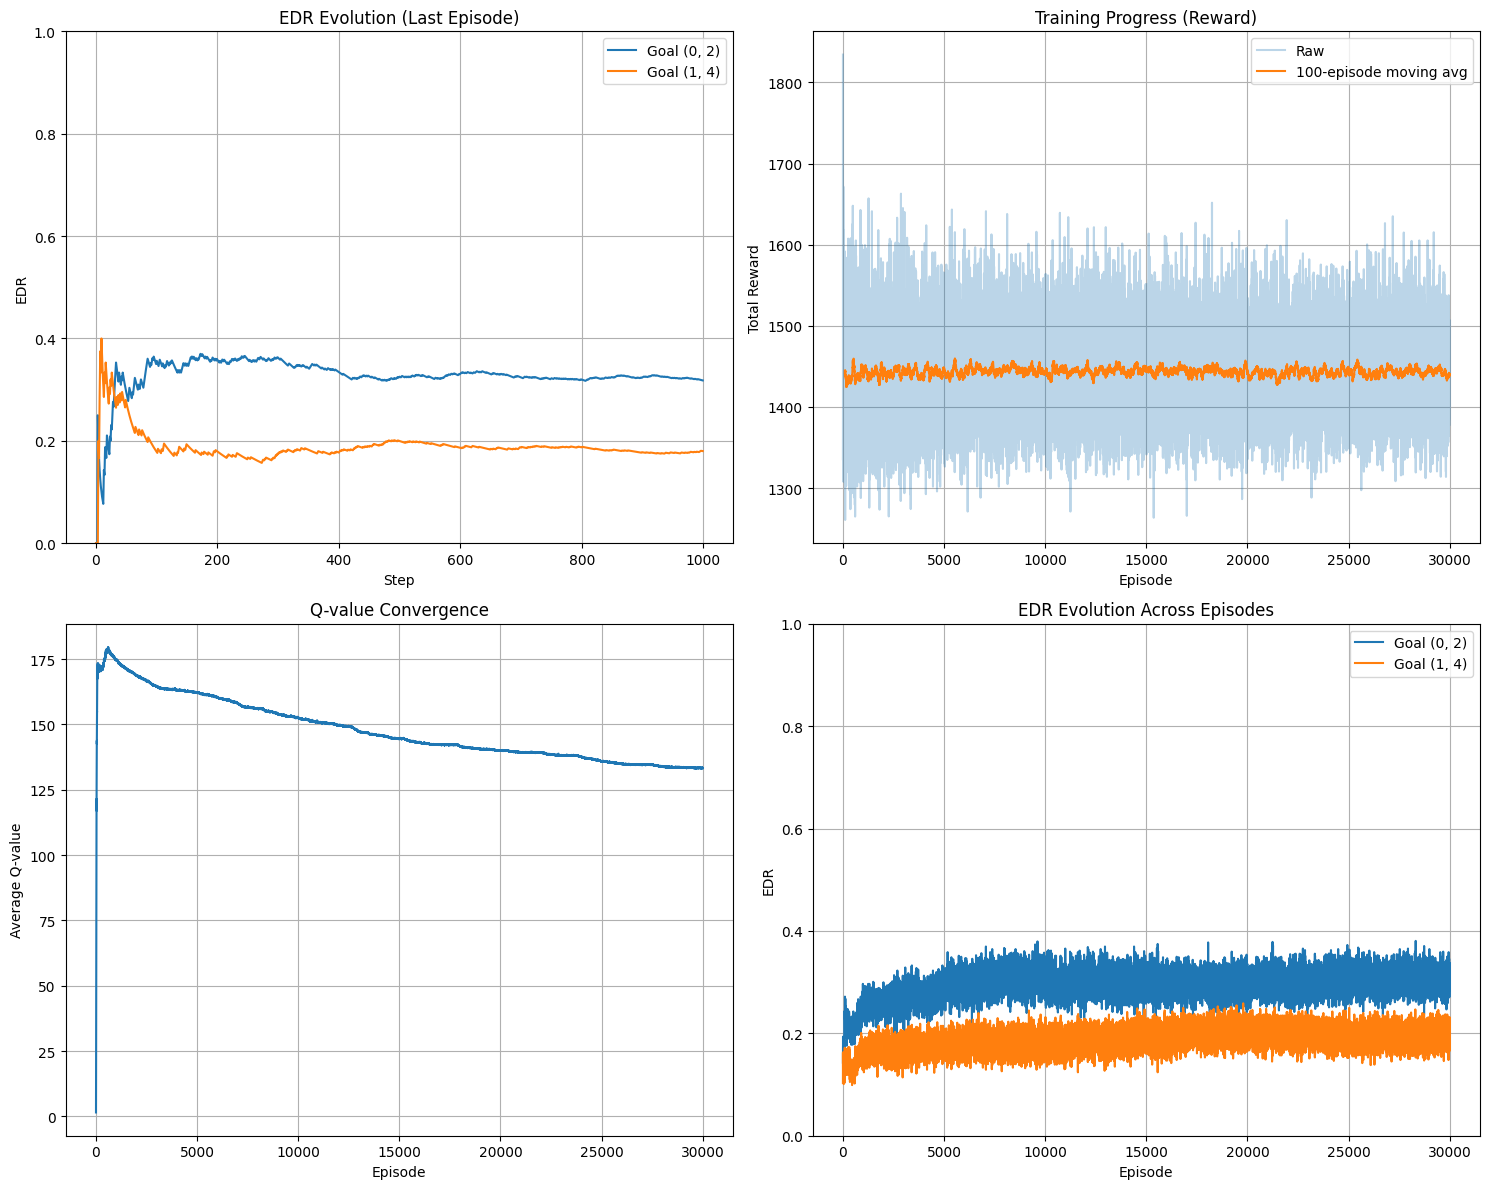


=== Convergence Statistics ===

Last 100 episodes:
Average reward: 1440.00
Reward std dev: 37.09
Average Q-value: 133.35

Final EDRs:
Goal (0, 2): 0.3103
Goal (1, 4): 0.1938

Last 500 episodes:
Average reward: 1440.24
Reward std dev: 43.71
Average Q-value: 133.37

Final EDRs:
Goal (0, 2): 0.3067
Goal (1, 4): 0.1956

Last 1000 episodes:
Average reward: 1442.93
Reward std dev: 45.77
Average Q-value: 133.42

Final EDRs:
Goal (0, 2): 0.3064
Goal (1, 4): 0.1958

=== Final Statistics ===
Parameters: pSwap=0.8, pGen=0.8, maxAge=2
Network: edges=[(0, 1), (1, 2), (2, 3), (3, 4)], goals=[(0, 2), (1, 4)]

Final EDRs (Last Episode):
Goal (0, 2): EDR = 0.318000
  - Successes: 318
  - Total timesteps: 1000
Goal (1, 4): EDR = 0.180000
  - Successes: 180
  - Total timesteps: 1000

Final Average Reward (last 100 episodes): 1439.9997


In [16]:
def getImmediateReward(achieved_goals, goal_success_counts, total_timesteps):
    if achieved_goals is None:
        return 0

    total_reward = 0
    for goal_edge, success in achieved_goals:
        if success:
            start, end = goal_edge
            num_edges = abs(end - start)
            instant_rate = pSwap ** (num_edges - 1)

            edr = max(0.0001, goal_success_counts[goal_edge] / max(1, total_timesteps))

            if instant_rate > 0 and edr > 0:
                total_reward += instant_rate / edr
    return total_reward

class QuantumNetworkQLearning:
    def __init__(self, edges, goalEdges, all_transitions, pSwap, pGen, maxAge):
        self.edges = edges
        self.goalEdges = goalEdges
        self.all_transitions = all_transitions
        self.pSwap = pSwap
        self.pGen = pGen
        self.maxAge = maxAge
        
        # Q-learning parameters
        self.alpha = 0.1
        self.gamma = 0.98
        self.epsilon = 0.3
        
        # Initialize Q-table using your transition structure
        self.Q = defaultdict(lambda: defaultdict(float))
        
        # Tracking variables
        self.goal_success_counts = {goal: 0 for goal in goalEdges}
        self.edr_history = {goal: [] for goal in goalEdges}
        self.reward_history = []
        
        # New convergence tracking variables
        self.episode_avg_q_values = []
        self.episode_avg_rewards = []
        self.episode_edrs = {goal: [] for goal in goalEdges}
        
    def group_transitions_by_action(self, state_transitions):
        """Group transitions by the attempted goals, ignoring success/failure"""
        action_groups = defaultdict(list)
        
        for next_state, prob, achieved_goals in state_transitions:
            if achieved_goals is None:
                action_key = None
            else:
                action_key = tuple(sorted(goal for goal, _ in achieved_goals))
            action_groups[action_key].append((next_state, prob, achieved_goals))
        
        return action_groups
    
    def choose_action(self, state, training=True):
        """Choose action using epsilon-greedy"""
        action_groups = self.group_transitions_by_action(self.all_transitions[state])
        
        if training and random.random() < self.epsilon:
            # Explore: random action group
            action_keys = list(action_groups.keys())
            chosen_key = random.choice(action_keys)
            transitions = action_groups[chosen_key]
        else:
            # Exploit: best action group based on Q-values
            best_value = float('-inf')
            best_transitions = None
            
            for action_key, transitions in action_groups.items():
                # Get average Q-value for this action group
                q_value = np.mean([self.Q[state][next_state] for next_state, _, _ in transitions])
                if q_value > best_value:
                    best_value = q_value
                    best_transitions = transitions
            
            transitions = best_transitions
        
        # Choose specific transition based on probabilities
        probs = [t[1] for t in transitions]
        return random.choices(transitions, weights=probs)[0]
    
    def train(self, num_episodes=1000, max_steps=100):
        window_size = 100  # For moving averages
        
        for episode in range(num_episodes):
            state = tuple((edge, -1) for edge in self.edges)
            episode_reward = 0
            total_timesteps = 1
            episode_q_values = []
            self.goal_success_counts = {goal: 0 for goal in self.goalEdges}
            
            for step in range(max_steps):
                # Choose and execute action
                next_state, prob, achieved_goals = self.choose_action(state, training=True)
                
                # Update goal successes
                if achieved_goals is not None:
                    for goal_edge, success in achieved_goals:
                        if success:
                            self.goal_success_counts[goal_edge] += 1
                
                # Get reward
                reward = getImmediateReward(achieved_goals, self.goal_success_counts, total_timesteps)
                episode_reward += reward
                
                # Q-learning update
                old_q = self.Q[state][next_state]
                next_q = max([self.Q[next_state][ns] for ns, _, _ in self.all_transitions[next_state]], default=0)
                self.Q[state][next_state] = old_q + self.alpha * (reward + self.gamma * next_q - old_q)
                
                # Track Q-values for convergence
                episode_q_values.append(self.Q[state][next_state])
                
                # Update EDR tracking
                for goal in self.goalEdges:
                    current_edr = self.goal_success_counts[goal] / total_timesteps
                    if episode == num_episodes - 1:  # Only track last episode
                        self.edr_history[goal].append(current_edr)
                
                # Transition
                state = next_state
                total_timesteps += 1
            
            # Store episode metrics
            self.reward_history.append(episode_reward)
            self.episode_avg_q_values.append(np.mean(episode_q_values))
            
            # Store EDRs for each goal at the end of episode
            for goal in self.goalEdges:
                self.episode_edrs[goal].append(self.goal_success_counts[goal] / total_timesteps)
            
            # Calculate moving averages for reward
            if len(self.reward_history) >= window_size:
                avg_reward = np.mean(self.reward_history[-window_size:])
                self.episode_avg_rewards.append(avg_reward)
            
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.reward_history[-100:])
                print(f"Episode {episode + 1}, Average Reward (last 100): {avg_reward:.2f}")
                print("Current EDRs:", {g: self.goal_success_counts[g]/total_timesteps for g in self.goalEdges})
    
    def plot_results(self):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: EDR evolution (last episode)
        for goal, edr_values in self.edr_history.items():
            ax1.plot(range(len(edr_values)), edr_values, label=f'Goal {goal}')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('EDR')
        ax1.set_title('EDR Evolution (Last Episode)')
        ax1.grid(True)
        ax1.legend()
        ax1.set_ylim(0, 1)
        
        # Plot 2: Reward history
        ax2.plot(self.reward_history, alpha=0.3, label='Raw')
        if len(self.episode_avg_rewards) > 0:  # Only plot if we have moving averages
            ax2.plot(range(99, len(self.episode_avg_rewards) + 99), 
                    self.episode_avg_rewards, 
                    label='100-episode moving avg')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Total Reward')
        ax2.set_title('Training Progress (Reward)')
        ax2.grid(True)
        ax2.legend()
        
        # Plot 3: Average Q-value evolution
        ax3.plot(self.episode_avg_q_values)
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Average Q-value')
        ax3.set_title('Q-value Convergence')
        ax3.grid(True)
        
        # Plot 4: EDR evolution across episodes
        for goal, edr_values in self.episode_edrs.items():
            ax4.plot(range(len(edr_values)), edr_values, label=f'Goal {goal}')
        ax4.set_xlabel('Episode')
        ax4.set_ylabel('EDR')
        ax4.set_title('EDR Evolution Across Episodes')
        ax4.grid(True)
        ax4.legend()
        ax4.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
        # Print convergence statistics
        print("\n=== Convergence Statistics ===")
        window_sizes = [100, 500, 1000]
        for window in window_sizes:
            if len(self.reward_history) >= window:
                print(f"\nLast {window} episodes:")
                print(f"Average reward: {np.mean(self.reward_history[-window:]):.2f}")
                print(f"Reward std dev: {np.std(self.reward_history[-window:]):.2f}")
                print(f"Average Q-value: {np.mean(self.episode_avg_q_values[-window:]):.2f}")
                print("\nFinal EDRs:")
                for goal in self.goalEdges:
                    print(f"Goal {goal}: {np.mean(self.episode_edrs[goal][-window:]):.4f}")

# Example usage
edges = [(0, 1), (1, 2), (2, 3), (3,4)]
goalEdges = [(0, 2), (1, 4)]
pSwap = 0.8
pGen = 0.8
maxAge = 2

# First generate all transitions using your existing code
all_transitions = generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge)

# Create and train agent
agent = QuantumNetworkQLearning(
    edges=edges,
    goalEdges=goalEdges,
    all_transitions=all_transitions,
    pSwap=pSwap,
    pGen=pGen,
    maxAge=maxAge
)
agent.train(num_episodes=30000, max_steps=1000)
agent.plot_results()

# Print final statistics
print("\n=== Final Statistics ===")
print(f"Parameters: pSwap={pSwap}, pGen={pGen}, maxAge={maxAge}")
print(f"Network: edges={edges}, goals={goalEdges}")

print("\nFinal EDRs (Last Episode):")
total_timesteps = len(next(iter(agent.edr_history.values())))
for goal in agent.goalEdges:
    final_edr = agent.goal_success_counts[goal] / total_timesteps
    print(f"Goal {goal}: EDR = {final_edr:.6f}")
    print(f"  - Successes: {agent.goal_success_counts[goal]}")  # Changed this line
    print(f"  - Total timesteps: {total_timesteps}")

print(f"\nFinal Average Reward (last 100 episodes): {np.mean(agent.reward_history[-100:]):.4f}")